In [114]:
%load_ext autoreload
%autoreload 2
    
from importlib import reload
import numpy as np
import dataset
from dataset import *

from utils import *
import utils
# from firthlogist import FirthLogisticRegression
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import scipy

from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from dataset import *

study = "two"
df = get_data(study)
idvar = "uid" if study=="one" else "id"

if study=="one":
    feat_cols = ['uid', 'lalco', 'ldep', 'llife', 'lcrim', 'ralco', 'rdep', 'rlife', 'rcrim', 'chosen', 
                 'alcodiff', 'depdiff', 'lifediff', 'crimdiff', 'secElasped', 'pairid']
    diffcols = ['lifediff', 'crimdiff', 'alcodiff', 'depdiff']
    
    reg_columns = range(9, 13)
if study=="two":
    feat_cols = ['id', 'l_elderlyDep', 'l_lifeYearsGained', 'l_obesity', 'l_weeklyWorkhours', 'l_yearsWaiting', 
                 'r_elderlyDep', 'r_lifeYearsGained', 'r_obesity', 'r_weeklyWorkhours', 'r_yearsWaiting', 
                 'eldepdiff', 'lifediff', 'obesdiff', 'workdiff', 'waitdiff', 'chosen', 'secElasped', 'pairid']
    diffcols = ['eldepdiff', 'lifediff', 'obesdiff', 'workdiff', 'waitdiff']
    reg_columns = range(11, 16)

df_lim = df[feat_cols]
users = df_lim[idvar].unique()

In [63]:
# create a function that get coefficient of each feature for each participant with logistic regression
def get_coef(df, user_id):
    df_user = df[df[idvar] == user_id]
    log = sm.GLM.from_formula(formula='chosen ~ ' + '+'.join(diffcols), data=df_user, family=sm.families.Binomial()) 
    result = log.fit() 
    return result.params
    

In [68]:
# get coefficient for each user and save it in a dictionary
coef_dict = {}
for i in users:
    idx = str(i)
    coefs = np.array(get_coef(df_lim, i))
    coefs = list(coefs/np.linalg.norm(coefs))  
    coef_dict[idx] = coefs
    

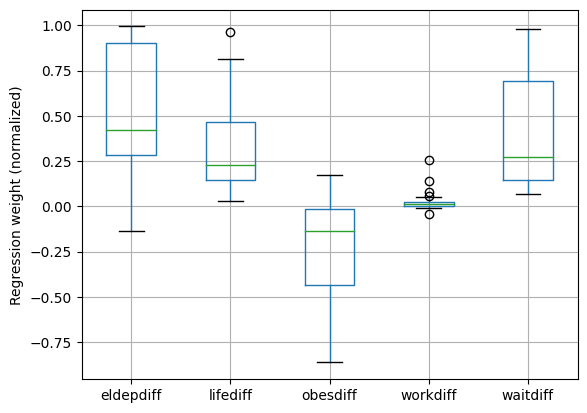

In [69]:
# create a dataframe from the dictionary with each row as user and each column as feature
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index', columns=['intercept'] + diffcols)
coef_df['user_id'] = coef_df.index

# coef_df
coef_df.boxplot(diffcols)
plt.ylabel("Regression weight (normalized)")
plt.show()

## Stability analysis

In [90]:
if study == "one":
    pair_ids = ['easy1', 'easy2', 'easy3', 'hard1', 'hard2', 'hard3']
else:
    pair_ids = ['easy_1', 'easy_2', 'easy_3', 'hard_1', 'hard_2', 'hard_3']

stability_scenarios = {}
for pairid in pair_ids:
    scenario = list(df_lim[df_lim["pairid"] == pairid].iloc[0][diffcols])
    print (pairid, scenario)
    stability_scenarios[pairid] = list(scenario)


easy_1 [-2, -15, 1, 10, -2]
easy_2 [1, 10, -2, 30, 0]
easy_3 [0, 0, -3, 10, 6]
hard_1 [1, 5, -1, -20, -2]
hard_2 [1, -10, -3, -20, 2]
hard_3 [-2, -5, -2, -10, 4]


In [99]:
cols = diffcols + ['chosen']

diff_scores = []
for id in pd.unique(df[idvar]):
    df_single = df_lim[df_lim[idvar] == id]
    coefs = coef_df[coef_df["user_id"] == str(id)]
    coefs = list(coefs.iloc[0])[1:-1]
    coefs = np.array(coefs)/np.linalg.norm(coefs)

    for pairid in pair_ids:
        df_single_pair = df_single[df_single["pairid"] == pairid][cols]
        df_single_pair["comb"] = sum([df_single_pair[c] for c in diffcols])
        df_single_pair["reverse"] = df_single_pair["comb"] != sum([stability_scenarios[pairid][i] for i in range(len(diffcols))])
    
        df_single_pair["reverse"] = df_single_pair["reverse"].astype(int)
        df_single_pair["chosen_updated"] = df_single_pair["chosen"] * (1-df_single_pair["reverse"]) + (1-df_single_pair["chosen"]) * df_single_pair["reverse"]

        stability = sum(df_single_pair["chosen_updated"])/len(df_single_pair["chosen_updated"])
        stability = (max(stability, 1-stability))
        
        score = (abs(np.dot(stability_scenarios[pairid], coefs)))
        diff_scores.append((id, pairid, score, stability))

diff_scores_pd = pd.DataFrame(data=diff_scores, columns=["userid", "pairid", "difficulty_score", "stability"])


In [110]:
# for pairid in pair_ids:
#     print (pairid, np.mean(diff_scores_pd[diff_scores_pd["pairid"] == pairid]["stability"]))

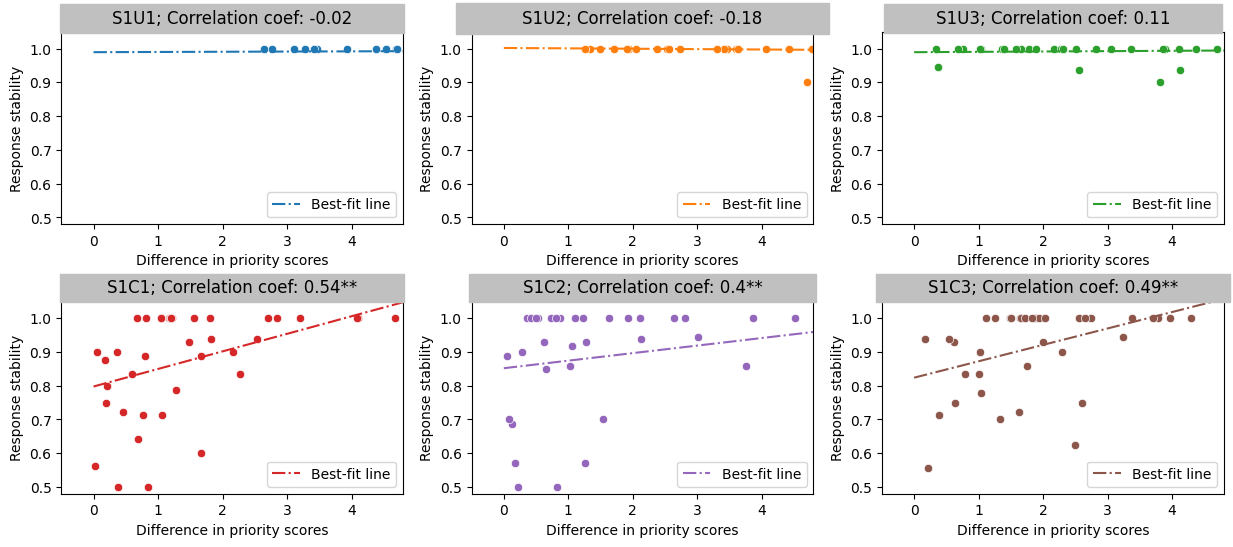

In [111]:
plt.figure(figsize=(15, 6))

labs = ["S1U1", "S1U2", "S1U3", "S1C1", "S1C2", "S1C3"]
# pair_ids = ["easy_1", "easy_2", "easy_3", "hard_1", "hard_2", "hard_3"]
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, pairid in enumerate(pair_ids):
    df_sub = diff_scores_pd[diff_scores_pd["pairid"] == pairid]
    plt.subplot(2,3,i+1)
    sns.scatterplot(data=df_sub, x='difficulty_score', y='stability', c=c[i])

    corr = scipy.stats.spearmanr(df_sub["difficulty_score"], df_sub["stability"]).statistic
    corr = 0 if np.isnan(corr) else corr
    corr = np.round(corr, 2)
    pval = scipy.stats.spearmanr(df_sub["difficulty_score"], df_sub["stability"]).pvalue
    pind = "**" if pval<0.05 else ""

    xs = list(df_sub["difficulty_score"])
    ys = list(df_sub["stability"])
    xs2 = np.linspace(0, 5, 101)
    plt.plot(xs2, np.poly1d(np.polyfit(xs, ys, 1))(xs2), "-.", c=c[i], label="Best-fit line")    
    plt.xlabel("Difference in priority scores")
    plt.ylabel("Response stability")
    plt.ylim([0.48, 1.05])
    plt.xlim([-0.5, 4.8])
    plt.legend(loc="lower right")

    title = plt.title(labs[i] + "; Correlation coef: "+ str(corr)+pind, backgroundcolor='silver', color='black')
    title._bbox_patch._mutation_aspect = 0.1
    if i == 1:
        title.get_bbox_patch().set_boxstyle("square", pad=4)
    elif i == 4:
        title.get_bbox_patch().set_boxstyle("square", pad=3.2)        
    elif i == 3:
        title.get_bbox_patch().set_boxstyle("square", pad=2.8)        
    elif i > 2:
        title.get_bbox_patch().set_boxstyle("square", pad=3.1)
    else:
        title.get_bbox_patch().set_boxstyle("square", pad=3.1)
    


plt.subplots_adjust(hspace=0.4)
plt.show()


In [112]:
from scipy.stats import permutation_test

def statistic(x, y):
    return (np.corrcoef(x, y)[0,1])

x = list(diff_scores_pd["difficulty_score"])
y = list(diff_scores_pd["stability"])
res = permutation_test((x, y), statistic, n_resamples=1000, permutation_type="pairings", alternative='greater')
res.statistic, res.pvalue



(0.37458989484423444, 0.000999000999000999)

In [115]:
model = sm.MixedLM.from_formula("stability ~ difficulty_score", re_formula="~difficulty_score", groups="userid", data=diff_scores_pd)
result = model.fit()
print (result.summary())

stargazer = Stargazer([result])
# print(stargazer.render_latex())
HTML(stargazer.render_html())

/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      stability
No. Observations:        240          Method:                  REML     
No. Groups:              40           Scale:                   0.0069   
Min. group size:         6            Log-Likelihood:          215.2745 
Max. group size:         6            Converged:               No       
Mean group size:         6.0                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.889    0.025 36.249 0.000  0.841  0.937
difficulty_score               0.017    0.007  2.327 0.020  0.003  0.031
userid Var                     0.012    0.115                           
userid x difficulty_score Cov -0.002    0.028                        

/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 30.334630
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
